<a href="https://colab.research.google.com/github/itssofiarce/AA2-TP2-Alomar-Arce/blob/main/ej_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descripción:
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

Dataset:
https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

# Librerías

In [1]:
#rm -rf data

In [2]:
!pip install tensorflow

In [3]:
!pip install pydub

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds #  La versión estable, lanzada cada pocos meses.
import pandas as pd
from typing import Optional
from tensorflow_datasets.core import dataset_info # de aca viene el dataset

# Construcción y carga del Dataset


In [5]:
tfds.builder('xtreme_s').info # full_name

tfds.core.DatasetInfo(
    name='xtreme_s',
    full_name='xtreme_s/fleurs.af_za/2.0.0',
    description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    XTREME-S covers four task families: speech recognition, classification, speech-to-text translation and retrieval. Covering 102
    languages from 10+ language families, 3 different domains and 4
    task families, XTREME-S aims to simplify multilingual speech
    representation evaluation, as well as catalyze research in “universal” speech representation learning.
    
    In this version, only the FLEURS dataset is provided, which covers speech
    recognition and speech-to-text translation.
    """,
    config_description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    """,
    homepage='https://arxiv.org/abs/2205.12446',
    data_dir=PosixGPa

In [6]:
#DATASET_PATH = 'data'

#data_dir = pathlib.Path(DATASET_PATH)
#lan = {'español':'es_419', 'ingles': 'en_us', 'frances':'fr_fr', 'japones': 'ja_jp'}

In [7]:
#for key, value in lan.items():
#    # Traigo solamente una parte del subset de test para agilizar la carga
#    tfds.load(f'xtreme_s/fleurs.{value}', split='test[:1%]', shuffle_files=False, data_dir=data_dir / key)
#
#    # Limpiar y quedarme unicamente con los audios que me insteresan
#    !mv data/{key}/downloads/audio data/{key}
#    !rm -rf data/{key}/downloads
#    !rm -rf data/{key}/xtreme_s


In [8]:
from google.colab import drive
drive.mount('/content/drive')
# Con dataset reducido
df_audio = ('/content/drive/MyDrive/dataset_reducido')

Mounted at /content/drive


In [9]:
!rm -rf /content/audio_sets

In [10]:
! [ ! -d /content/audio_sets ] &&  mkdir /content/audio_sets
! cp -r /content/drive/MyDrive/dataset_reducido/* /content/audio_sets/

In [11]:
drive.flush_and_unmount() # para liberar espacio

In [12]:
df = '/content/audio_sets'
data_dir = pathlib.Path(df)

# Distribuciones de las clases


In [13]:
for dir in os.listdir(df):
    print(f'{dir}: {len(os.listdir(os.path.join(df, dir)))}')

frances: 200
ingles: 200
español: 200
japones: 200


Las clases estan balanceadas.

# Analisis Exploratorio


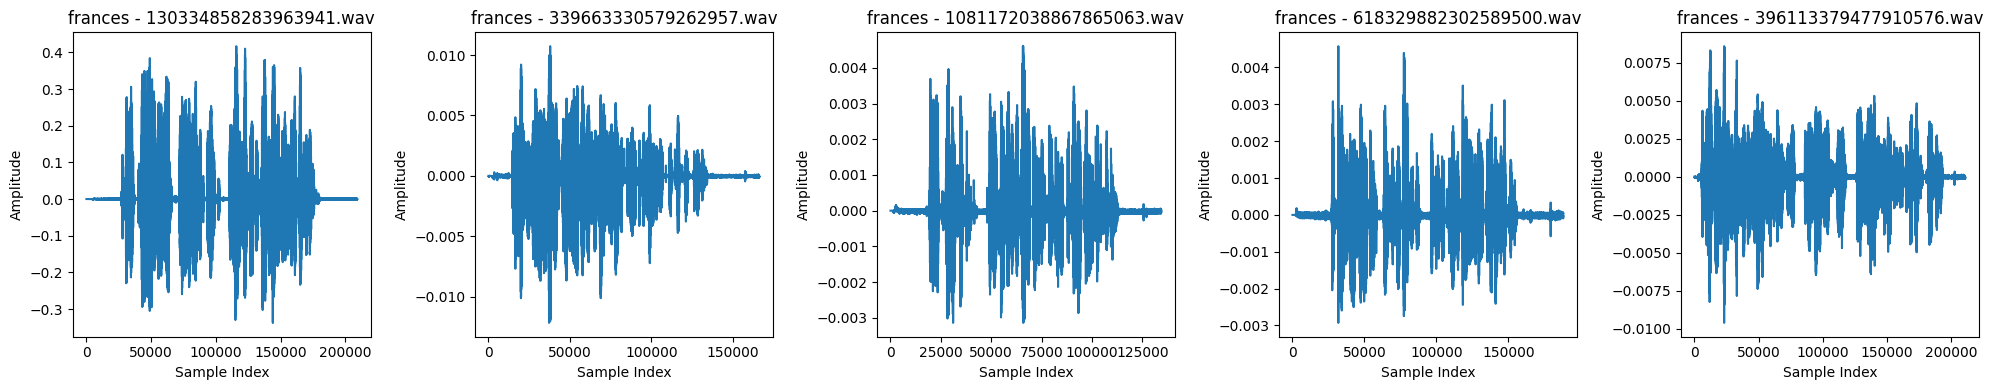

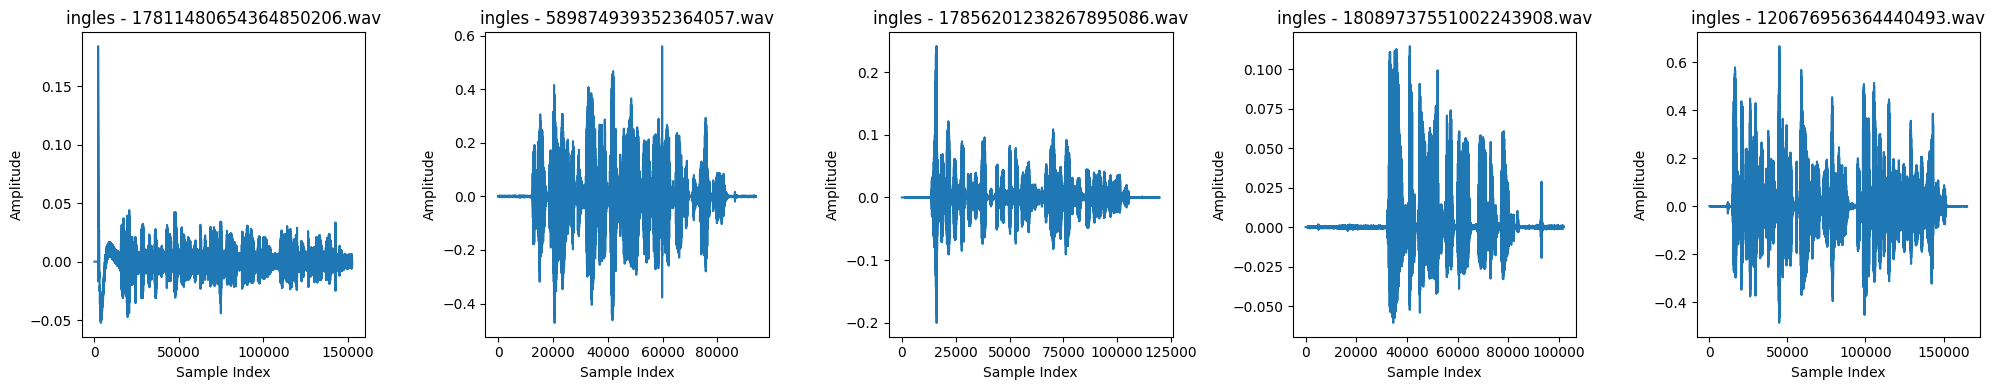

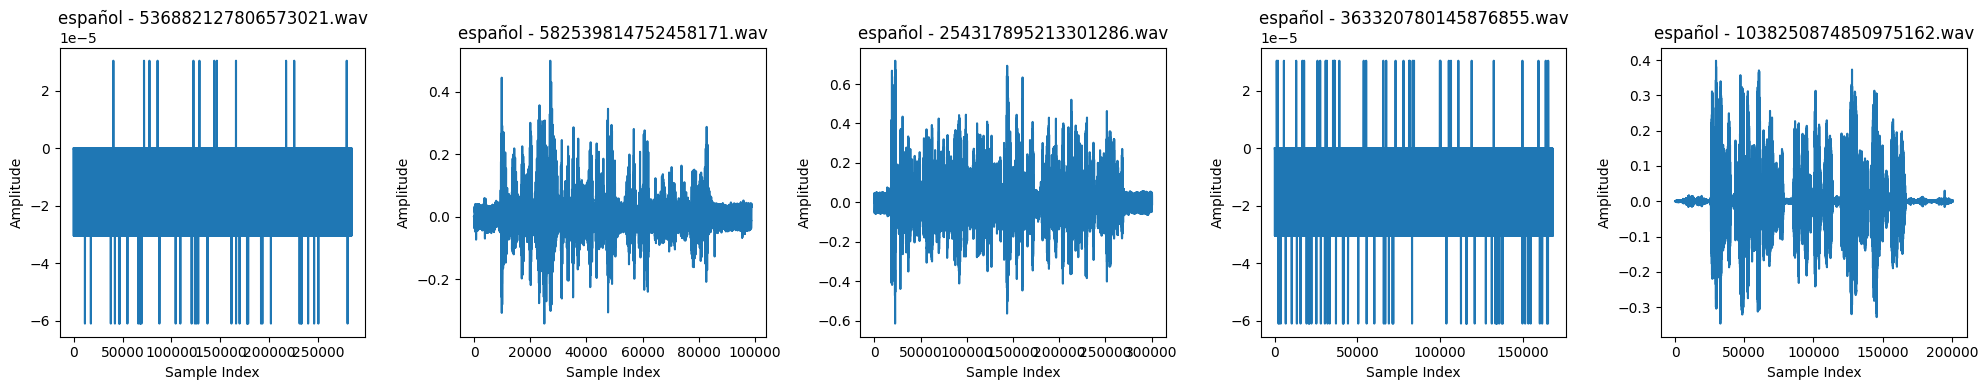

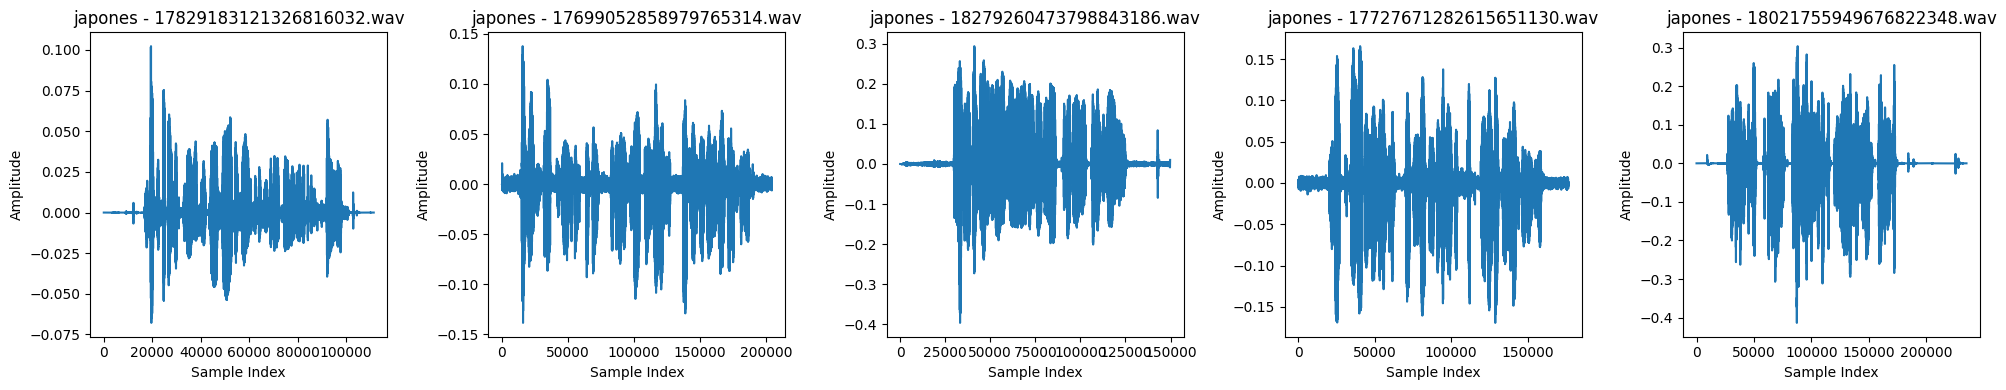

In [14]:
for dir in os.listdir(df):
    current_dir_path = os.path.join(df, dir)
    plt.figure(figsize=(20, 4))

    count = 1

    for wav in os.listdir(current_dir_path):
        if wav.endswith(".wav"):
            wav_path = os.path.join(current_dir_path, wav)
            audio = tf.audio.decode_wav(tf.io.read_file(wav_path))[0]
            plt.subplot(1, 5, count)
            plt.plot(audio.numpy())
            plt.title(f'{dir} - {wav}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')

            count += 1
            if count > 5:
                break

    plt.tight_layout()
    plt.show()

Segun los los primeros 5 wav files de cada idioma, la longitud de los audios varían entre 10kHz y 30kHz vemos la dimension de los audios.

In [138]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=125000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


In [16]:
train_ds.element_spec

(TensorSpec(shape=(None, 125000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

**shape=(None, 16000, None)**
  - Batch Size: No tiene
  - Audio Samples: No seteamos nigun output_sequence_length, por lo que a las secuencias del mismo bache se les agregó padding de la longitud del audio mas largo.
  - Numero de canales: Mono

**dtype=tf.int32:**
 - Tipo de Dato: Int32

**name=None**
  - Nombre: No tiene


Al ser audios mono, vamos a dropear el 3 componente de shape para mejorar la eficiencia y compatibilidad a la hora de entrenar el modelo con las capas que esperan 2D.


In [139]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Con .shard() spliteamos el dataset de validacion en dos mitades (num_shards=2), la primer mitad se la asignamos a test (index=0) y la segunda a validacion (index=1). Esto lo hacemos para subsanar a *audio_dataset_from_directory* ya que solo devuelve hasta dos sets (train y validación) y poder así obtener métricas mas significativas de nuestro modelo.

In [140]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Verificamos que el shape haya quedado de dos dimensiones.

In [141]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 125000)
(64,)


Ploteamos nuevamente las ondas de los audios.

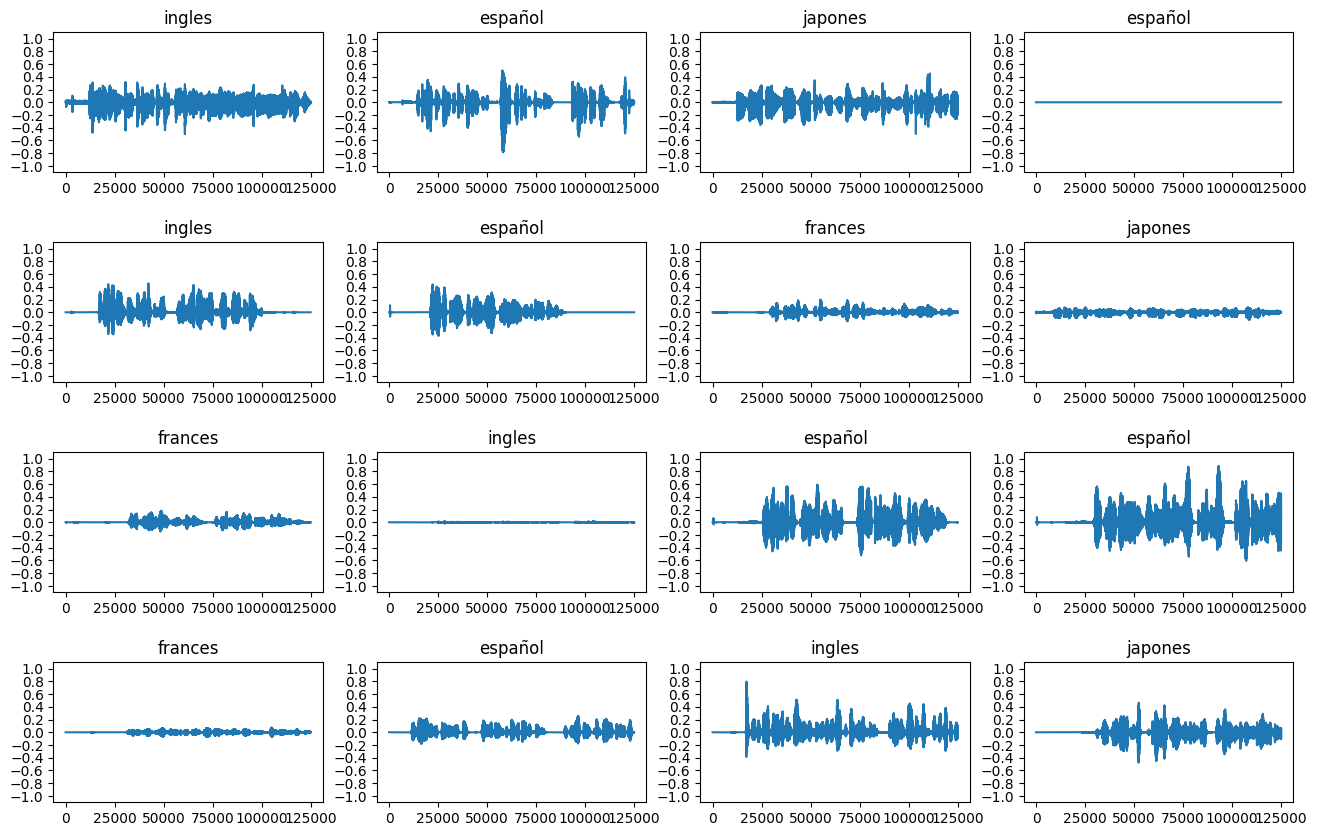

In [20]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.subplots_adjust(hspace=0.5)
  plt.ylim([-1.1, 1.1])

Al reducir los canales las ondas se vuelven mas "simples" en algunos clips hasta parece no haber sonido. Seguiremos por convertirlas en espectogramas y observar el cambio de frecuencias a través del tiempo. Y poder entrar a nuestro modelo con esas imagenes representadas en 2D.

# Espectogramas


In [21]:
def get_spectrogram(waveform):
  ''' Params:
      - waveform: los clips de los audios de la misma longitud. (nuestro dataset fue armado así)'''
  # STFT a diferencia de fft splitea la señal en ventans de timepo y calcula la transformadad de fourier para cada una, preservando algo del tiempo.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # el frame_length y el frame_step deben ser de forma tal que la "imagen" del espectograma sea casi cuadrada para que ...
  spectrogram = tf.abs(spectrogram) # magnitud del spectograma
  # Agrego una dimension de "canales" para que el se pueda usar la imagen del espectograma como input en las redes convolucionales
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [22]:
label_names[example_labels]

array(['ingles', 'español', 'japones', 'español', 'ingles', 'español',
       'frances', 'japones', 'frances', 'ingles', 'español', 'español',
       'frances', 'español', 'ingles', 'japones', 'español', 'frances',
       'japones', 'japones', 'frances', 'ingles', 'ingles', 'ingles',
       'ingles', 'frances', 'ingles', 'japones', 'japones', 'español',
       'ingles', 'ingles', 'ingles', 'español', 'frances', 'japones',
       'ingles', 'frances', 'frances', 'ingles', 'ingles', 'ingles',
       'japones', 'ingles', 'japones', 'ingles', 'frances', 'ingles',
       'frances', 'frances', 'japones', 'español', 'japones', 'ingles',
       'ingles', 'frances', 'frances', 'japones', 'frances', 'español',
       'español', 'frances', 'español', 'frances'], dtype='<U8')

In [23]:
clean_test=[]
i = 0
while len(clean_test) < 4:
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_test:
    clean_test.append(label)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=20000)) # rate es la velocidad mientras mas chico, mas lento.
  else:
    pass
  i += 1

Label: ingles
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: español
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: japones
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: frances
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Graficamos

In [108]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  if ax == None:
    ax = plt.gca()
  ax.pcolormesh(X, Y, log_spec)

AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

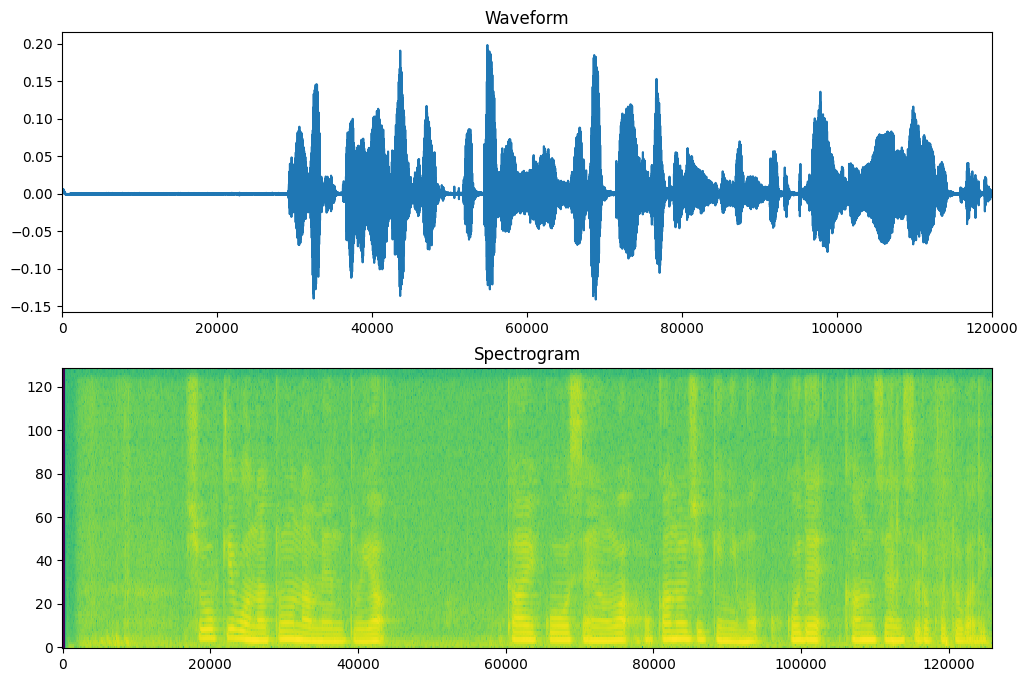

In [110]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 120000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.subtitle(label.title())
plt.show()

Armamos nuestro dataset de espectogramas


In [26]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [28]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

# pending to fix


0 hello
1 hello
2 hello
3 hello
4 hello
5 hello
6 hello
7 hello
8 hello
9 hello


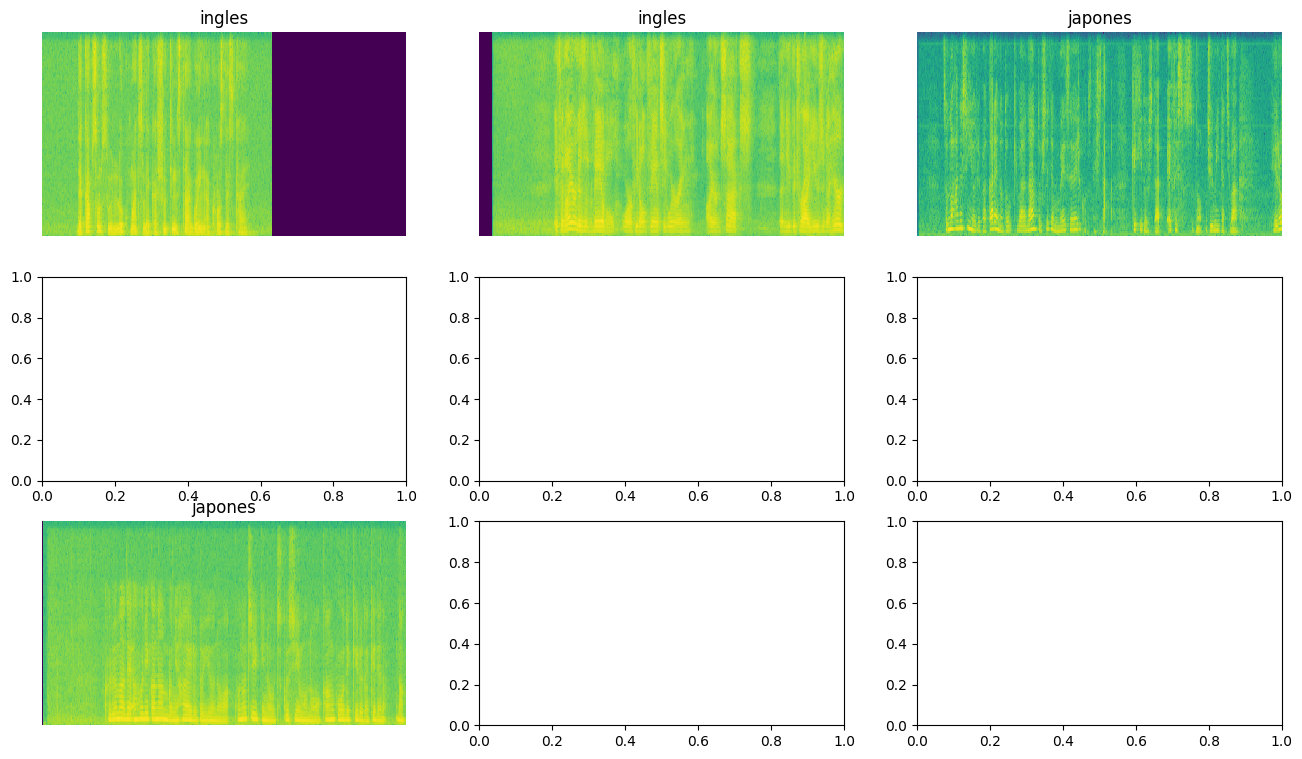

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

clean_spec=[]
i=0
while i != 10:
  print(i, "hello")
  label = label_names[example_labels[i]]

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_spec:

    clean_spec.append(label)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
    ax.axis('off')

  i += 1
  pass

plt.show()

# Modelo Convolucional

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (975, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,411,015 (28.27 MB)

 Trainable params: 7,411,012 (28.27 MB)

 Non-trainable params: 3 (16.00 B)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [33]:
EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.3178 - loss: 1.5706 - val_accuracy: 0.3750 - val_loss: 1.3461
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4780 - loss: 1.2170 - val_accuracy: 0.4375 - val_loss: 1.1280
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5849 - loss: 0.9756 - val_accuracy: 0.5938 - val_loss: 0.9666
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6936 - loss: 0.7685 - val_accuracy: 0.6250 - val_loss: 0.9012
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7318 - loss: 0.6761 - val_accuracy: 0.6250 - val_loss: 0.8986
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7365 - loss: 0.6414 - val_accuracy: 0.6250 - val_loss: 1.1031
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7728 - loss: 0.5188 - val_accuracy: 0.6406 - val_loss: 0.9703
Epoch 7: early stopping


# Analisis de las métricas


Text(0, 0.5, 'Accuracy [%]')

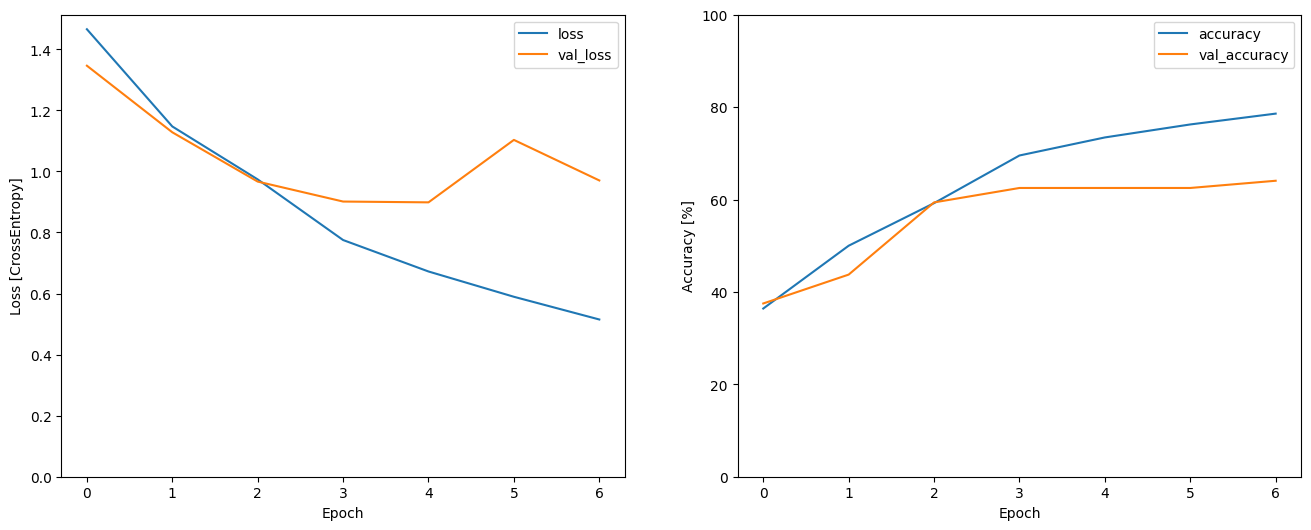

In [34]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

El modelo esta overfitteado de los datos de train ya que el accuracy es menor para el dataset de train y el loss es menor para este tambien.

In [35]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6562 - loss: 0.9271


{'accuracy': 0.65625, 'loss': 0.9385051727294922}

Para los datos no vistos el modelo convolucional tiene un accuracy de 59%

In [36]:
y_pred = model.predict(test_spectrogram_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


In [37]:
y_pred = tf.argmax(y_pred, axis=1)

In [38]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

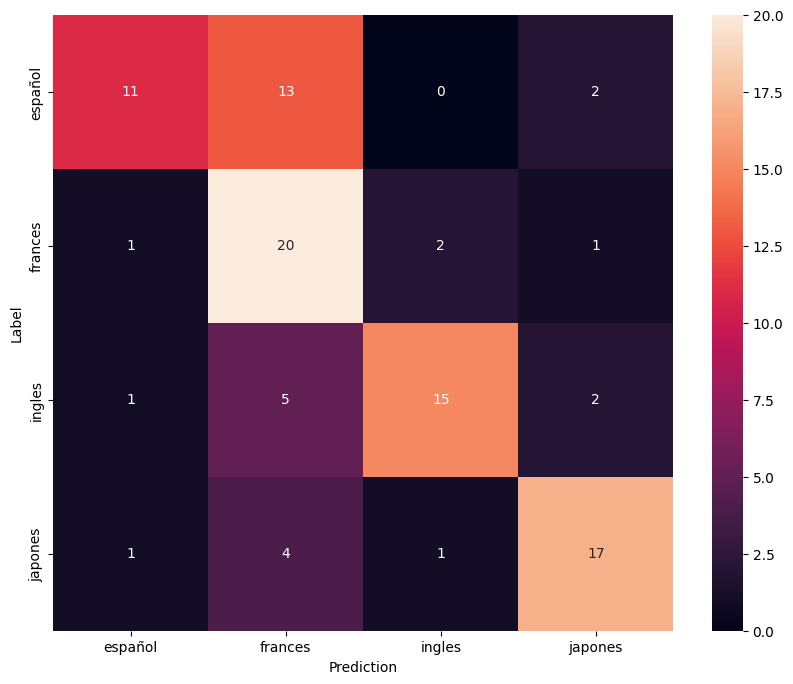

In [39]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    español       0.79      0.42      0.55        26
     frances       0.48      0.83      0.61        24
      ingles       0.83      0.65      0.73        23
     japones       0.77      0.74      0.76        23

    accuracy                           0.66        96
   macro avg       0.72      0.66      0.66        96
weighted avg       0.72      0.66      0.66        96



Conclusión del modelo convolucional en test de validación:

Es muy bueno para las instancias de "japones", tiene una precisión del 92% pero su capacidad para detectar correctamente los casos de japonés (recall) es solamente del 52%.
Tampoco confunde las clases de ffrances e ingles con las de los demas idiomas(recall del 79% y 65%). Pero para el español, confunde las instancias de en mayor cantidad con las de frances (recall bajo del 38%)


# Modelo Recurrente

In [184]:
img_height, img_width = 50, 50
segment_lenght = 10  # Número de frames a extraer por segmento
segment_stride = 5  # Desplazamiento entre segmentos

In [85]:
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical

In [157]:
rm -rf sample_spec_img

In [156]:
def load_video_classification_dataset(spec_ds, img_height, img_width, segment_lenght, segment_stride):
  spec_img_dir='sample_spec_img'

  # Save each spectrogram as an image
  for i, (example_spectrograms, example_spect_labels) in enumerate(spec_ds):
    plot_spectrogram(example_spectrograms[0].numpy(), None)
    # Save the plot as png into a folfer that has the name of the label
    if not os.path.exists(os.path.join(spec_img_dir, label_names[example_spect_labels[0].numpy()])):
      os.makedirs(os.path.join(spec_img_dir, label_names[example_spect_labels[0].numpy()]))

    plt.savefig(os.path.join(spec_img_dir,label_names[example_spect_labels[0].numpy()], f'spec_{i}_{label_names[example_spect_labels[0].numpy()]}.png'))
    plt.close()
    #Print the label
    print(label_names[example_spect_labels[0].numpy()])



In [174]:
import cv2

In [189]:
def load_video_classification_dataset_2(data_dir, img_height, img_width, segment_lenght, segment_stride):
    X, y = [], []
    for label, class_name in enumerate(label_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = sorted(os.listdir(class_dir))  # Sort to maintain sequence if needed

        # Create a list to hold the image frames for this class
        images = []
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_width, img_height))  # Resize image
            images.append(image)

            # Extraer segmentos de frames
        num_segments = (len(images) - segment_lenght) // segment_stride + 1
        for i in range(num_segments):
            start = i * segment_stride
            end = start + segment_lenght
            segment = images[start:end]
            if len(segment) == segment_lenght:
                X.append(segment)
                y.append(label)

    X = np.array(X)
    y = to_categorical(y, num_labels)
    return X, y

In [256]:
!pip uninstall opencv-python-headless -y
!pip install opencv-python --upgrade

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84


In [195]:
label_names

array(['español', 'frances', 'ingles', 'japones'], dtype='<U8')

In [244]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def load_image_classification_dataset_3(data_dir, img_height, img_width, segment_length, segment_stride, label_names):
    """
    Loads and preprocesses an image dataset for classification.

    Args:
        data_dir (str): Path to the dataset directory.
        img_height (int): Height to resize images to.
        img_width (int): Width to resize images to.
        segment_length (int): Number of consecutive images to form a segment.
        segment_stride (int): Step size between consecutive segments.
        label_names (list): List of class names for labeling.

    Returns:
        X (np.array): Array of image segments.
        y (np.array): Array of labels corresponding to image segments.
    """
    X, y = [], []

    for label, class_name in enumerate(label_names):

        #Voy por clase
        class_dir = os.path.join(data_dir, class_name)
        image_files = sorted(os.listdir(class_dir))  # Ordena los nombres de las imgenes.

        # Voy por imagen dentro de mi clase
        images = []
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            print(image_path)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_width, img_height))  # Resize image
            print(image.shape)


            # Voy por pixel dentro de mi imagen
            num_segments = (len(image) - segment_length) // segment_stride + 1
            print('num seg', num_segments)
            for i in range(num_segments):
              start = i * segment_stride
              end = start + segment_length
              segment = image[start:end]
              print(num_segments)
              if len(segment) == segment_length:
                  X.append(segment)
                  y.append(label)
        break

    X = np.array(X)
    y = to_categorical(y, num_classes=len(label_names))  # Convert labels to one-hot encoding
    return X, y


In [248]:
X, y = load_image_classification_dataset_3('/content/sample_spec_img', 50,50,10, 5,label_names)

/content/sample_spec_img/español/spec_1_español.png
(50, 50, 3)
num seg 9
9
9
9
9
9
9
9
9
9


In [234]:
from sklearn.model_selection import train_test_split

In [235]:
# Cargar y preprocesar los datos
#X, y = load_video_classification_dataset(data_dir, img_height, img_width, segment_lenght, segment_stride)

# Mezclar los datos antes de dividirlos en entrenamiento y validación
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Creo mi nuevo data set, con las particiones de los espectogramas


In [243]:
X_train.shape

(7, 10, 50, 3)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, LSTM, Dense

In [251]:
model_rnn = Sequential()
# Capas convolucionales
model_rnn.add(TimeDistributed(Conv2D(64, (2, 2), strides=(1,1),activation='relu'), input_shape=(segment_lenght, img_width, 3)))
model_rnn.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(MaxPooling2D((2,2))))
model_rnn.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(MaxPooling2D(2,2)))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(Flatten()))
model_rnn.add(Dropout(0.5))
# Capa recurrente
model_rnn.add(LSTM(32, return_sequences=False, dropout=0.5))
# Capas de salida
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(num_labels, activation='softmax'))
# Resumen del modelo
model_rnn.summary()

ValueError: Kernel shape must have the same length as input, but received kernel of shape (2, 2, 3, 64) and input of shape (None, 50, 3).

In [238]:
model_rnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [239]:
EPOCHS = 30
history = model_rnn.fit(
    X_train,
    validation_data=Y_train,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_9_1/Cast:0", shape=(None, 10, 50, 3), dtype=float32). Expected shape (None, 10, 50, 50, 3), but input has incompatible shape (None, 10, 50, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 10, 50, 3), dtype=uint8)
  • training=True
  • mask=None